In [1]:
from scipy.io import loadmat
from scipy.stats import circmean, circstd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

from utils import validate_data

## Loading all the data

In [2]:
# Set in stone
data_path = '../axej/'
n_subjects = 13
n_sessions = 4
n_runs = 6
n_trials = 120
n_ts = 500

exp_ts = 1000

# noise frames = 0 to 220 (250 - 30)
noise_thresh = 0.5
noise_gap = 30


experiment_orientations = [159, 123, 87, 51, 15]
subjects = ["01", "02", "03", "04", "05", "06", "07", "08" ,"09", "10", "11", "12", "14"]

def get_calib(subj, sess):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Cali1.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

def get_run(subj, sess, run):
    mat_contents = loadmat(data_path + f'AxeJEEG_Subj{subjects[subj]}_S{sess+1}_Run{run+1}.mat.mat', struct_as_record=False, squeeze_me=True)
    return mat_contents["p"].__dict__

In [3]:
# Get all run data
# subjexts x sessions x runs
jx = []
jy = []
stimdir = []
tgonset = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# ExpOrientation (expOri): 1,2,3,4,5 -> 159, 123, 87, 51, 15
att = []
coh = []
exp = []

for subj in tqdm(range(n_subjects)):
    for sess in range(n_sessions):
        for run in range(n_runs):

            data = get_run(subj, sess, run)
            jx.append(data["joyx"])
            jy.append(data["joyy"])
            stimdir.append(data["stimDirREAL"])

            f_tgonset = data["f_precuedur"] + data["f_cuedur"]
            tgonset.append(f_tgonset)

            att.append(data["attCue"])
            coh.append(data["tgCoh"])

            try:
                # print(data["expOri"])
                exp.append([experiment_orientations[data["expOri"] - 1]]*n_trials)
            except:
                # print("No expOri")
                exp.append([np.nan]*n_trials)
                

# Shape the run data
jx = np.array(jx, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
jy = np.array(jy, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials, n_ts)
stimdir = np.array(stimdir).reshape(n_subjects, n_sessions, n_runs, n_trials)
tgonset = np.array(tgonset).reshape(n_subjects, n_sessions, n_runs, n_trials)
att = np.array(att, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
coh = np.array(coh, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)
exp = np.array(exp, dtype=np.float64).reshape(n_subjects, n_sessions, n_runs, n_trials)

jx.shape, jy.shape, stimdir.shape, tgonset.shape, att.shape, coh.shape, exp.shape

100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


((13, 4, 6, 120, 500),
 (13, 4, 6, 120, 500),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120),
 (13, 4, 6, 120))

## Logic for Getting Valid Trials:

1. Get all the trials
2. Align all target onset at 250 ts
3. Get distance from center and angle from center
4. If the distance moves <0.4 au n frames before target onset. Then that trial is "too early" and all response set nan.
5. If ts has distance > 1 au then set its response angle to the last valid angle (if first, the nan) and set that distance to 1.
6. get angle first distance = 1 a.u. instance after target onset. or if it never reaches 1, then angle at max distance after target onset. as the response angle.

In [4]:
shifted_jx, shifted_jy, dist_from_cent, resp_angle, final_resp_angles = validate_data(n_subjects, n_sessions, n_runs, n_trials, n_ts, exp_ts, jx, jy, tgonset, noise_thresh, noise_gap)

In [5]:
# Get all trials where angles are only nan
nan_trials = np.where(np.isnan(resp_angle).all(axis=-1))
print(nan_trials[0].shape[0], "removed trials")
print(nan_trials[0].shape[0] / (n_subjects * n_sessions * n_runs * n_trials) * 100, "% removed trials")

2919 removed trials
7.7964743589743595 % removed trials


## Circular stat defs

In [6]:
def circdist(a, b):
    return min(abs(a-b), 360-abs(a-b))

def circmedian(angs):
    angs = np.array(angs)
    angs = angs[~np.isnan(angs)]
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + 180) % (2 * 180) - 180
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [7]:
calib_median = np.load("../cache/calib_results/circ_median.npy")
median_key = {15:0, 51:1, 87:2, 123:3, 159:4}

In [8]:
calib_std = np.load("../cache/calib_results/circ_std.npy")
std_key = {15:0, 51:1, 87:2, 123:3, 159:4}

## Design Matrix

Things that are considered as u_t

- Calibrated stimulus (median)
- Coherece
- Attention 
- Expectation

compared:

- bias

In [9]:
final_resp_angles.shape, stimdir.shape, exp.shape

((13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120))

In [10]:
stimulus = np.zeros((n_subjects, n_sessions, n_runs, n_trials))
exp_cali = np.zeros((n_subjects, n_sessions, n_runs, n_trials))

for subj in range(n_subjects):
    for sess in range(n_sessions):
        for run in range(n_runs):
            for trial in range(n_trials):
                target_key = median_key[stimdir[subj, sess, run, trial]]
                stimulus[subj, sess, run, trial] = calib_median[subj, target_key]

                exp_t = exp[subj, sess, run, trial]
                if np.isnan(exp_t):
                    exp_cali[subj, sess, run, trial] = np.nan
                else:
                    exp_key = median_key[exp_t]
                    exp_cali[subj, sess, run, trial] = calib_median[subj, exp_key]

#### Attention + Coherence + Expectation:

In [11]:
# Coherence (tgCoh): tr_lo = 1, tr_hi = 2
# coh = []

# Attention (attCue): tr_foc = 1, tr_div = 2
# att = []

# ExpOrientation (expOri): 1,2,3,4,5 -> 159, 123, 87, 51, 15 -> calib_median
# exp_cali = []

In [12]:
coh.shape, att.shape, exp_cali.shape

((13, 4, 6, 120), (13, 4, 6, 120), (13, 4, 6, 120))

In [13]:
coh[coh == 1] = 0
coh[coh == 2] = 1

att[att == 1] = 1
att[att == 2] = 0

## Cleanup and standardization

In [14]:
# Remove trials with no expectation manipulation

exp_obs = final_resp_angles[:, :, :5, :].reshape(-1, 120)

exp_stim = stimulus[:, :, :5, :]
exp_coh = coh[:, :, :5, :]
exp_att = att[:, :, :5, :]
exp_exp = exp_cali[:, :, :5, :]

exp_design_matrix = np.stack([exp_stim, exp_coh, exp_att, exp_exp], axis=-1).reshape(-1, 120, 4)

exp_stim.shape, exp_coh.shape, exp_att.shape, exp_exp.shape, exp_obs.shape, exp_design_matrix.shape

((13, 4, 5, 120),
 (13, 4, 5, 120),
 (13, 4, 5, 120),
 (13, 4, 5, 120),
 (260, 120),
 (260, 120, 4))

In [15]:
# Remove "too early" trials

good_obs = []
good_design = []

for idx, run in enumerate(exp_obs):
    
    run_mask = np.isnan(run)

    good_obs.append(run[~run_mask])
    good_design.append(exp_design_matrix[idx][~run_mask])

In [16]:
len(good_obs), len(good_design)

(260, 260)

Text(0, 0.5, 'Trials')

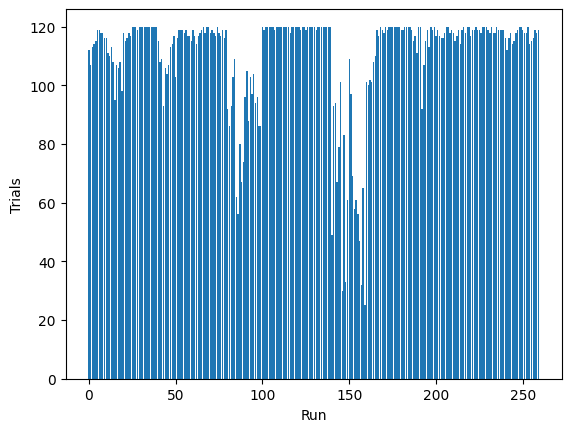

In [17]:
length_good = [len(x) for x in good_obs]
plt.bar(list(range(260)),length_good)
plt.xlabel("Run")
plt.ylabel("Trials")

In [18]:
min(length_good)

25

In [19]:
# Randomly sample x trials in order from each run 
repeats = 5
resample_size = 20

np.random.seed(0)

sampled_obs = []
sampled_design = []

for _ in range(repeats):
    for run_obs, run_des in zip(good_obs, good_design):
        
        sample_idx = sorted(np.random.choice(len(run_obs), resample_size, replace=False))

        sampled_obs.append(run_obs[sample_idx])
        sampled_design.append(run_des[sample_idx])

len(sampled_obs), len(sampled_design)

(1300, 1300)

In [20]:
# check if there are any nan values
tot_nan = 0
for session in np.array(sampled_obs).reshape(-1, resample_size):
    if np.isnan(session).any():
        tot_nan += 1

f"{tot_nan}/312 trials contain nan values"

'0/312 trials contain nan values'

In [21]:
valid_obs = np.expand_dims(np.array(sampled_obs), -1)
valid_design = np.array(sampled_design)

valid_obs.shape, valid_design.shape

((1300, 20, 1), (1300, 20, 4))

In [25]:
np.save("../cache/data_prep/exp_obs.npy", valid_obs)
np.save("../cache/data_prep/exp_design.npy", valid_design)